**Importing DataSet**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries**

In [2]:
pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=701e246dc4462555cbeb3fa276afaa08a6514439ecced3998614be597c8de959
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [3]:
import os
import glob
from glob import glob
import os, glob, pickle
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
from scipy.io import wavfile
from scipy import signal



from python_speech_features import mfcc
import librosa
import librosa as lr
from IPython.display import Audio

<ipython-input-3-ceec1800550d>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import soundfile
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

**Uploading DataSet**

In [5]:
paths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data'):
  for filename in filenames:
    paths.append(os.path.join(dirname, filename))
print("Dataset is uploaded")
len(paths)

Dataset is uploaded


1442

In [6]:
paths[:5]

['/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_17/03-01-03-01-02-01-17.wav',
 '/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_17/03-01-03-01-01-02-17.wav',
 '/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_17/03-01-01-01-01-01-17.wav',
 '/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_17/03-01-02-01-02-01-17.wav',
 '/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_17/03-01-03-01-01-01-17.wav']

**DataSet Visualisation Using Graphs & Spectrograms**

In [7]:
def envelope(y, rate, threshold):
  mask = []
  y = pd.Series(y).apply(np.abs)
  y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
  for mean in y_mean:
    if mean>threshold:
      mask.append(True)
    else:
      mask.append(False)
    return mask

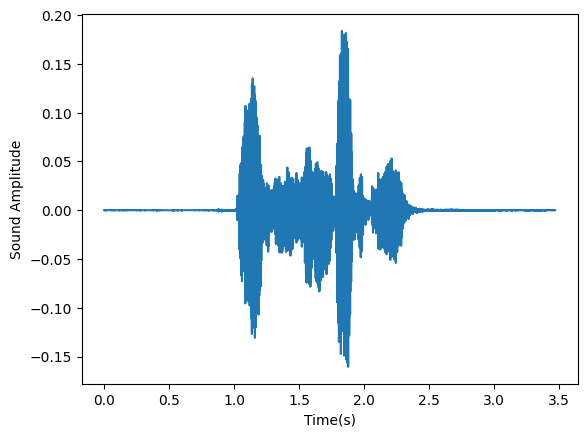

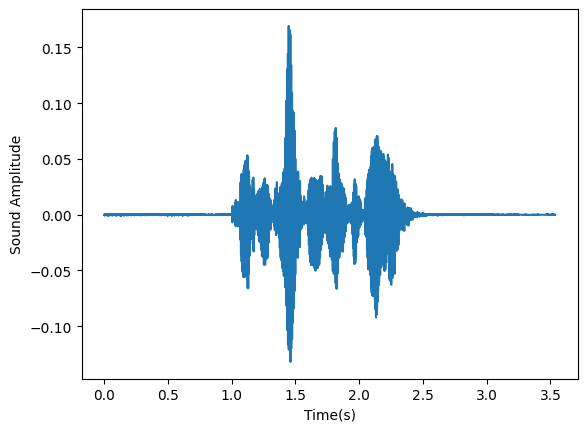

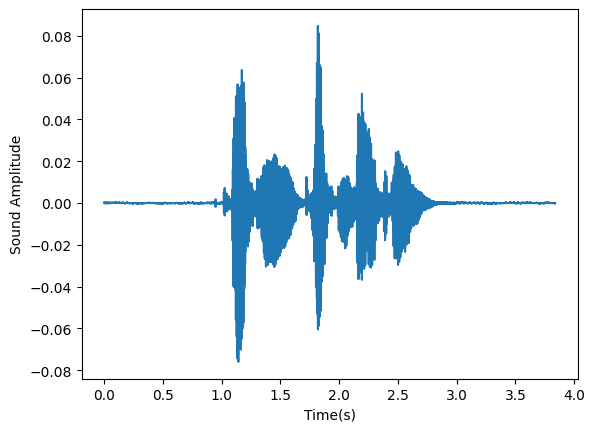

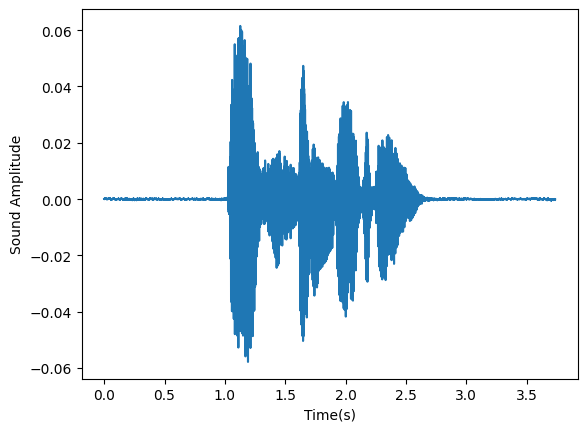

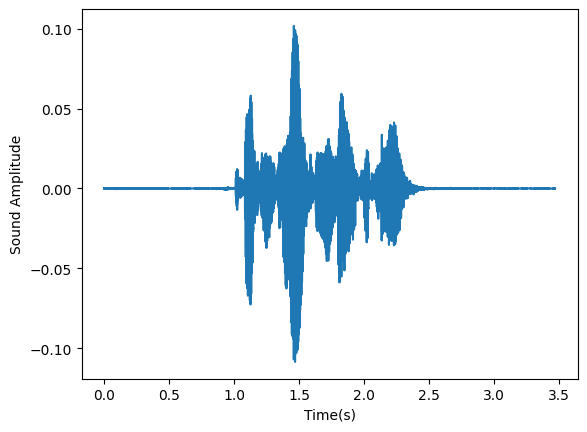

In [8]:
for file in range(0, 5, 1):
  audio, sfreq = lr.load(paths[file])
  time = np.arange(0, len(audio))/sfreq

  fig, ax = plt.subplots()
  ax.plot(time, audio)
  ax.set(xlabel = 'Time(s)', ylabel = 'Sound Amplitude')
  plt.show()

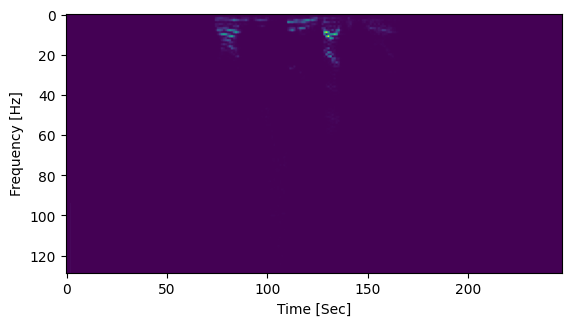

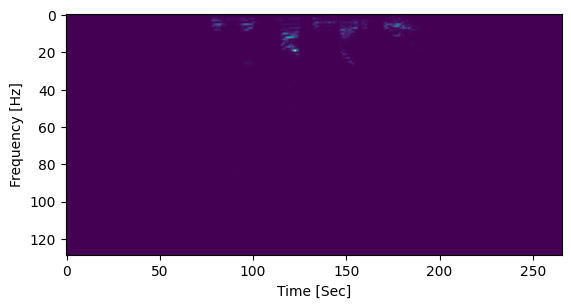

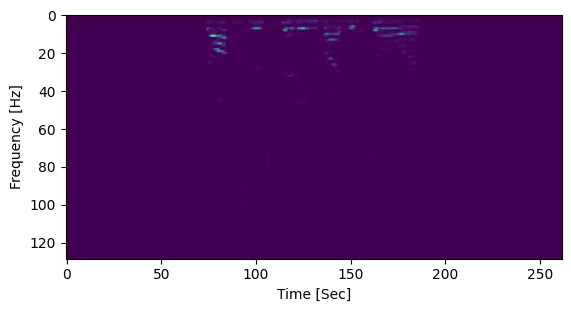

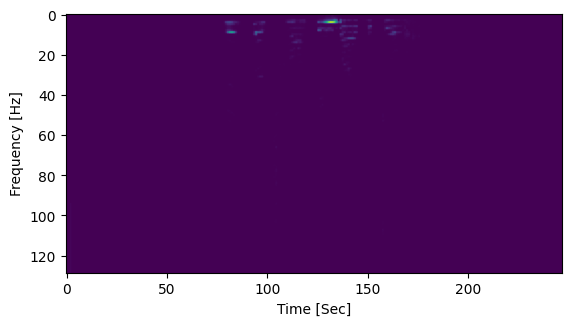

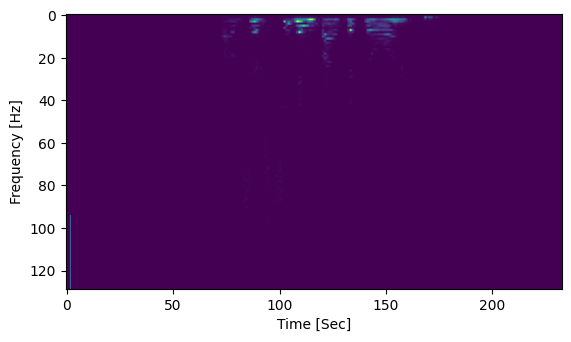

In [9]:
for file in range(0, 500, 100):
  sample_rate, sample = wavfile.read(paths[file])
  frequencies, times, spectrogram = signal.spectrogram(sample, sample_rate)
  plt.pcolormesh(times, frequencies, spectrogram)
  plt.imshow(spectrogram)
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [Sec]')


  plt.show()



**Feature Extraction From Audiofiles**

In [10]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
   # mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
       # if mel:
          #  mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
           # result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

**Emotions Available**

In [11]:
emotions = {
    '01' : 'neutral',
    '02' : 'calm',
    '03' : 'happy',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fearful',
    '07' : 'disguist',
    '08' : 'surprised',
}
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}



**Loading The DataSet**

In [15]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in tqdm(glob.glob("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_*//*.wav")):
        file_name=os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
          # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [16]:
x_train, x_test, y_train, y_test = load_data(test_size=0.25)
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

  0%|          | 0/1442 [00:00<?, ?it/s]

(505, 52) (169, 52) (505,) (169,)


In [17]:
print((x_train.shape[0], x_test.shape[0]))
print('Features extracted:',x_train.shape[1])

(505, 169)
Features extracted: 52


**Defining The Model**

In [18]:
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive',max_iter=500)
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

**Saving The File In Pickle Format**

In [19]:
import pickle

Pkl_Filename ='SER_Model.pkl'

with open(Pkl_Filename, 'wb') as file:
  pickle.dump(model, file)

In [20]:
Pkl_Filename ='SER_Model.pkl'

with open(Pkl_Filename, 'rb') as file:
  SER_Model = pickle.load(file)

SER_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [21]:
y_pred = SER_Model.predict(x_test)
y_pred

array(['happy', 'sad', 'angry', 'angry', 'neutral', 'sad', 'happy',
       'angry', 'angry', 'happy', 'happy', 'happy', 'neutral', 'sad',
       'happy', 'angry', 'happy', 'neutral', 'happy', 'sad', 'happy',
       'sad', 'angry', 'angry', 'neutral', 'sad', 'sad', 'neutral',
       'neutral', 'sad', 'angry', 'sad', 'angry', 'sad', 'happy', 'angry',
       'angry', 'happy', 'sad', 'happy', 'neutral', 'happy', 'angry',
       'happy', 'sad', 'angry', 'sad', 'angry', 'happy', 'sad', 'sad',
       'angry', 'angry', 'happy', 'sad', 'sad', 'angry', 'happy', 'sad',
       'neutral', 'happy', 'happy', 'angry', 'happy', 'happy', 'angry',
       'sad', 'happy', 'neutral', 'angry', 'happy', 'sad', 'sad',
       'neutral', 'sad', 'neutral', 'angry', 'neutral', 'happy', 'sad',
       'happy', 'neutral', 'happy', 'neutral', 'neutral', 'sad', 'sad',
       'sad', 'happy', 'sad', 'angry', 'angry', 'angry', 'sad', 'neutral',
       'sad', 'sad', 'sad', 'angry', 'sad', 'happy', 'happy', 'angry',
       

**Accuracy Of The Model**

In [22]:
# Calculate the accuracy of our model
a=accuracy_score(y_test,y_pred)
# Print the accuracy
print("Accuracy:", a*100 )

Accuracy: 74.55621301775149


**Classification Of  Emotions**

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.87      0.83      0.85        47
       happy       0.67      0.67      0.67        46
     neutral       0.73      0.70      0.72        27
         sad       0.71      0.76      0.73        49

    accuracy                           0.75       169
   macro avg       0.75      0.74      0.74       169
weighted avg       0.75      0.75      0.75       169



**Data Input**

Enter the path of audio signal/content/drive/MyDrive/TESS Toronto emotional speech set data/YAF_angry/YAF_bar_angry.wav


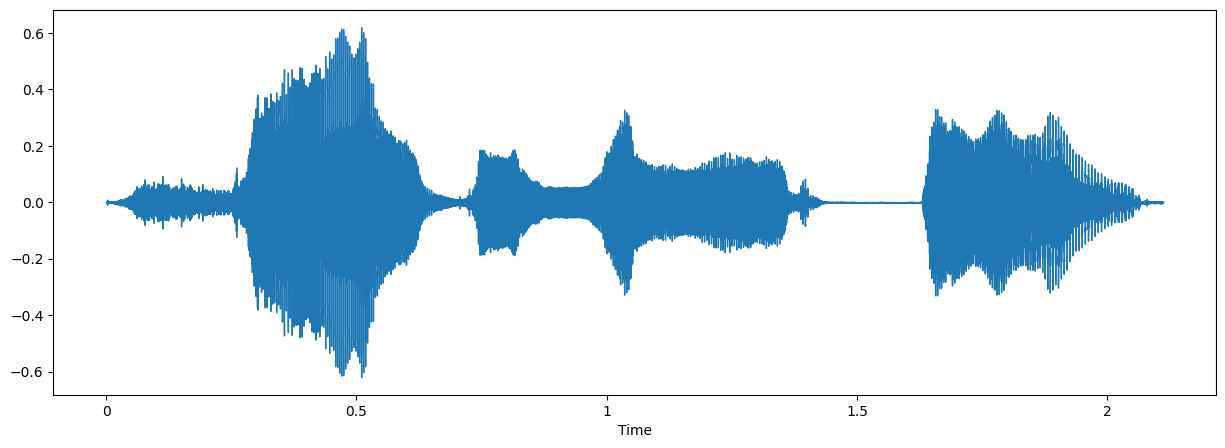

In [24]:
audio=input('Enter the path of audio signal')
data, sampling_rate = librosa.load(audio)
%matplotlib inline
plt.figure(figsize=(15,5))
librosa.display.waveshow(data, sr=sampling_rate)
Audio(audio)

In [25]:
filename = (audio)
    #record_to_file(filename)
    # extract features and reshape it
features = extract_feature(filename, mfcc=True, chroma=True).reshape(1, -1)
    # predict
result = SER_Model.predict(features)[0]
    # show the result !
print("result:", result)

result: angry
